<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

# import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
color = sns.color_palette()
from gplearn.genetic import SymbolicRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,make_scorer
# algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


# modeling helper functions
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score, train_test_split

In [2]:
fnc_df = pd.read_csv("C:/OpenClassRooms/projet 8/trends-assessment-prediction/fnc.csv")
loading_df = pd.read_csv("C:/OpenClassRooms/projet 8/trends-assessment-prediction/loading.csv")

fnc_features, loading_features = list(fnc_df.columns[1:]), list(loading_df.columns[1:])
df = fnc_df.merge(loading_df, on="Id")


labels_df = pd.read_csv("C:/OpenClassRooms/projet 8/trends-assessment-prediction/train_scores.csv")
labels_df["is_train"] = True

df = df.merge(labels_df, on="Id", how="left")

test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()

In [3]:
target_cols = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']
df.drop(['is_train'], axis=1, inplace=True)
test_df = test_df.drop(target_cols + ['is_train'], axis=1)

# Giving less importance to FNC features since they are easier to overfit due to high dimensionality.
FNC_SCALE = 1/500

df[fnc_features] *= FNC_SCALE
test_df[fnc_features] *= FNC_SCALE

In [4]:
features = loading_features + fnc_features

In [5]:
df

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,IC_20,IC_30,IC_22,IC_29,IC_14,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,0.000737,0.000334,0.000876,0.000682,-0.000373,0.000098,0.000243,-0.000349,-0.000463,...,0.010496,0.002892,-0.023235,0.022177,0.017192,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,0.000303,-0.000050,0.000435,0.000836,-0.000454,-0.000128,-0.000288,-0.000236,-0.000110,...,0.005739,0.002880,-0.016609,0.025543,0.014524,59.580851,50.969456,67.470628,60.651856,58.311361
3,10004,0.000266,0.000517,0.000982,0.000685,0.000182,0.000216,0.000058,-0.000052,0.000189,...,-0.000319,0.005866,-0.015182,0.024476,0.014760,71.413018,53.152498,58.012103,52.418389,62.536641
4,10005,0.000584,0.000503,0.000833,0.001023,-0.000725,-0.000329,-0.000578,-0.000031,-0.000175,...,0.000786,0.002692,-0.019814,0.017105,0.013316,66.532630,NaN,NaN,52.108977,69.993075
6,10007,0.000047,0.000504,0.001143,0.000677,-0.000209,-0.000399,-0.000482,-0.000382,-0.000057,...,0.003731,0.000733,-0.008462,0.026733,0.014358,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11745,21746,0.000079,0.000156,0.000832,0.000874,-0.000235,0.000256,0.000124,-0.000409,-0.000201,...,0.006943,0.003312,-0.011562,0.032932,0.011053,14.257265,21.358872,61.165998,51.778483,54.640179
11746,21747,0.000484,0.000417,0.001205,0.001266,-0.000267,-0.000428,-0.000785,-0.000450,-0.000775,...,0.001316,0.003792,-0.022357,0.031624,0.016982,55.456978,68.169675,29.907995,55.349257,54.019517
11749,21750,0.000456,-0.000445,0.000501,0.000885,-0.000442,-0.000470,-0.000593,-0.000546,-0.000213,...,0.004942,0.007751,-0.020226,0.028821,0.017492,48.948756,55.114811,60.878271,38.617246,50.679885
11751,21752,0.000237,0.000904,0.001217,0.000845,-0.000213,-0.000017,-0.000020,-0.000244,0.000186,...,0.002026,0.001876,-0.014612,0.021665,0.019592,66.532630,59.844808,72.303110,55.458281,46.870235


In [6]:
test_df

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
2,10003,0.000687,0.000220,0.001483,0.001157,-0.001353,-0.000874,-0.000591,-0.000756,-0.000690,...,0.019565,0.030616,0.018184,-0.010469,0.029799,0.015435,0.005211,-0.028882,0.031427,0.018164
5,10006,0.000647,0.000234,0.001281,0.000641,-0.000639,-0.000606,-0.000428,-0.000713,-0.000471,...,0.006948,0.019818,0.003582,-0.010414,0.023518,0.005929,0.005046,-0.030771,0.028500,0.022485
9,10010,-0.000453,-0.000087,0.000669,0.000638,-0.000342,-0.000519,-0.000279,0.000070,0.000181,...,0.001252,0.020002,0.013935,-0.005653,0.013281,0.003379,0.004841,-0.009467,0.027287,0.014542
10,10011,0.000335,0.000332,0.001042,0.000810,-0.000311,-0.000076,-0.000104,0.000104,0.000174,...,0.014015,0.022257,0.008814,-0.003944,0.027572,0.008287,0.000210,-0.013350,0.033612,0.019472
11,10012,0.001039,0.000594,0.001191,0.001549,-0.001016,-0.000164,0.000077,0.000038,0.000344,...,0.010726,0.026314,0.007632,-0.010203,0.022945,0.007642,0.003368,-0.024025,0.024723,0.024084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11744,21745,0.000306,0.000575,0.000905,0.001231,-0.000543,-0.000057,0.000076,0.000732,0.000611,...,0.009398,0.024635,0.013140,-0.007455,0.023625,0.005393,0.007665,-0.011987,0.027616,0.018392
11747,21748,-0.000591,0.000218,0.000652,0.001475,-0.000644,-0.000127,-0.000349,-0.000195,-0.000150,...,0.011172,0.017172,0.003079,-0.007329,0.021157,0.007605,0.009629,-0.019956,0.024192,0.017368
11748,21749,0.000249,0.000055,0.000757,0.000974,0.000061,0.000305,-0.000051,0.000234,0.000099,...,0.010015,0.017097,0.016017,-0.003296,0.018724,0.008006,-0.000521,-0.001333,0.029249,0.015356
11750,21751,0.000910,0.000968,0.001179,0.001267,0.000324,-0.000351,0.000031,0.000271,0.000345,...,0.012303,0.018314,0.012326,-0.012152,0.024617,0.002096,0.001911,-0.008028,0.035093,0.017439


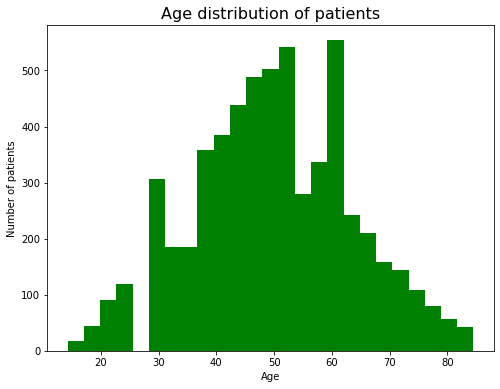

In [7]:
#No Missing Values
x = df['age']
plt.figure(figsize=(8,6))
plt.hist(x, bins=25, color='g')
plt.xlabel('Age')
plt.ylabel('Number of patients')
plt.title('Age distribution of patients', fontsize = 16)
plt.show()

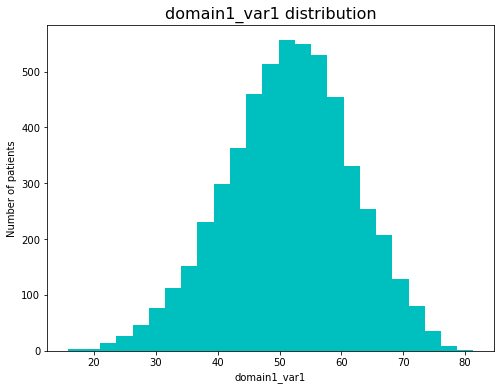

In [8]:
x = df['domain1_var1']
plt.figure(figsize=(8,6))
plt.hist(x, bins=25, color='c')
plt.xlabel('domain1_var1')
plt.ylabel('Number of patients')
plt.title('domain1_var1 distribution', fontsize = 16)
plt.show()

In [9]:
#We can see that domain1_var1 distribution is approximately normal. So, we will fill the missing values with mean.
df['domain1_var1'].fillna(df['domain1_var1'].mean(), inplace=True)

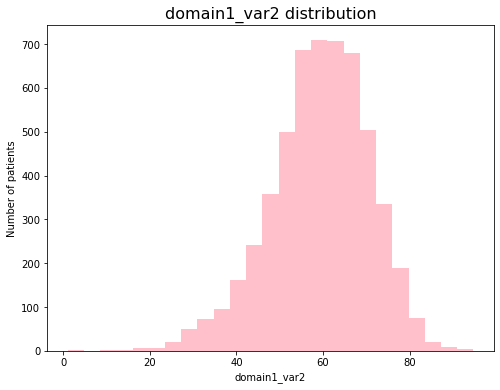

In [10]:
x = df['domain1_var2']
plt.figure(figsize=(8,6))
plt.hist(x, bins=25, color='pink')
plt.xlabel('domain1_var2')
plt.ylabel('Number of patients')
plt.title('domain1_var2 distribution', fontsize = 16)
plt.show()

In [11]:
#domain1_var2 is skewed. So, we will fill missing values with median.
df['domain1_var2'].fillna(df['domain1_var2'].median(), inplace=True)

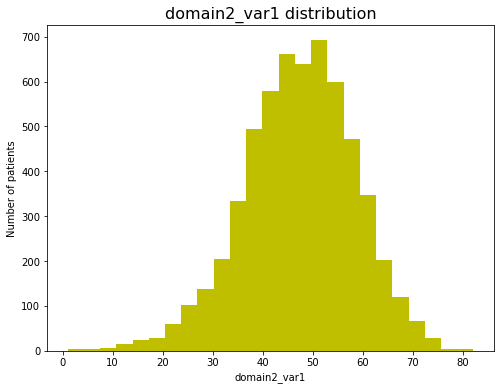

In [12]:
x = df['domain2_var1']
plt.figure(figsize=(8,6))
plt.hist(x, bins=25, color='y')
plt.xlabel('domain2_var1')
plt.ylabel('Number of patients')
plt.title('domain2_var1 distribution', fontsize = 16)
plt.show()

In [13]:
#domain2_var1 is approximately normal. So, we will fill missing values with mean.
df['domain2_var1'].fillna(df['domain2_var1'].mean(), inplace=True)

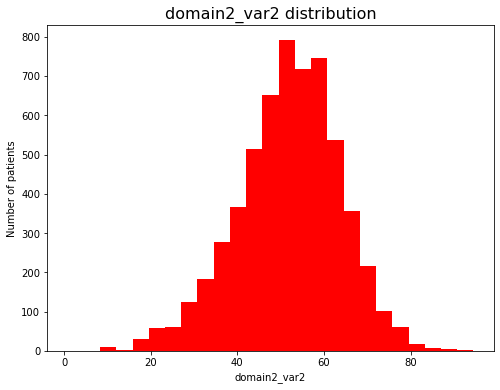

In [14]:
x = df['domain2_var2']
plt.figure(figsize=(8,6))
plt.hist(x, bins=25, color='r')
plt.xlabel('domain2_var2')
plt.ylabel('Number of patients')
plt.title('domain2_var2 distribution', fontsize = 16)
plt.show()

In [15]:
#domain2_var2 is approximately normal. So, we will fill missing values with mean.
df['domain2_var2'].fillna(df['domain2_var2'].mean(), inplace=True)

In [16]:
df

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,IC_20,IC_30,IC_22,IC_29,IC_14,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,0.000737,0.000334,0.000876,0.000682,-0.000373,0.000098,0.000243,-0.000349,-0.000463,...,0.010496,0.002892,-0.023235,0.022177,0.017192,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,0.000303,-0.000050,0.000435,0.000836,-0.000454,-0.000128,-0.000288,-0.000236,-0.000110,...,0.005739,0.002880,-0.016609,0.025543,0.014524,59.580851,50.969456,67.470628,60.651856,58.311361
3,10004,0.000266,0.000517,0.000982,0.000685,0.000182,0.000216,0.000058,-0.000052,0.000189,...,-0.000319,0.005866,-0.015182,0.024476,0.014760,71.413018,53.152498,58.012103,52.418389,62.536641
4,10005,0.000584,0.000503,0.000833,0.001023,-0.000725,-0.000329,-0.000578,-0.000031,-0.000175,...,0.000786,0.002692,-0.019814,0.017105,0.013316,66.532630,51.474692,60.052535,52.108977,69.993075
6,10007,0.000047,0.000504,0.001143,0.000677,-0.000209,-0.000399,-0.000482,-0.000382,-0.000057,...,0.003731,0.000733,-0.008462,0.026733,0.014358,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11745,21746,0.000079,0.000156,0.000832,0.000874,-0.000235,0.000256,0.000124,-0.000409,-0.000201,...,0.006943,0.003312,-0.011562,0.032932,0.011053,14.257265,21.358872,61.165998,51.778483,54.640179
11746,21747,0.000484,0.000417,0.001205,0.001266,-0.000267,-0.000428,-0.000785,-0.000450,-0.000775,...,0.001316,0.003792,-0.022357,0.031624,0.016982,55.456978,68.169675,29.907995,55.349257,54.019517
11749,21750,0.000456,-0.000445,0.000501,0.000885,-0.000442,-0.000470,-0.000593,-0.000546,-0.000213,...,0.004942,0.007751,-0.020226,0.028821,0.017492,48.948756,55.114811,60.878271,38.617246,50.679885
11751,21752,0.000237,0.000904,0.001217,0.000845,-0.000213,-0.000017,-0.000020,-0.000244,0.000186,...,0.002026,0.001876,-0.014612,0.021665,0.019592,66.532630,59.844808,72.303110,55.458281,46.870235


In [17]:
X_train, X_test, y_train_age, y_test_age = train_test_split(test_df, df['age'],
                                                    train_size=0.75, test_size=0.25, random_state=42)

In [18]:
#X_train.reset_index(drop=True,inplace=True)
X_train

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
4252,14253,0.000629,0.000286,0.000946,0.001074,-0.000360,0.000009,-0.000312,-3.240460e-05,0.000239,...,0.010266,0.021415,0.002672,-0.009482,0.026320,0.006791,0.007550,-0.011825,0.022898,0.017293
7848,17849,0.000585,0.000132,0.001015,0.000719,-0.000135,0.000095,0.000390,1.715400e-07,0.000286,...,0.006515,0.013330,0.012619,-0.010503,0.017011,-0.002394,0.002945,-0.007193,0.031912,0.012971
11240,21241,0.000608,0.000191,0.001041,0.000589,-0.000663,-0.000263,-0.000122,-5.744669e-04,-0.000244,...,0.015512,0.023997,0.017933,-0.013739,0.031075,0.005248,0.002884,-0.019851,0.032812,0.021750
4792,14793,0.000133,0.000365,0.000872,0.000324,-0.000272,-0.000097,-0.000602,2.014913e-04,0.000471,...,0.010195,0.014296,0.009723,-0.010389,0.018163,0.005299,0.004920,-0.009413,0.020560,0.009772
1195,11196,0.001039,0.000968,0.001497,0.001405,-0.000972,-0.000786,-0.000549,-6.558664e-04,-0.000695,...,0.012748,0.027905,0.007253,-0.004257,0.028048,0.011213,0.006383,-0.013387,0.028911,0.023699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7462,17463,0.001246,0.001412,0.001619,0.001524,-0.000354,-0.000002,-0.000391,-1.247933e-03,-0.001139,...,0.010080,0.020766,0.017258,-0.008875,0.021729,0.008477,-0.001392,-0.019578,0.036914,0.016372
10338,20339,0.000157,0.000270,0.000973,0.000806,0.000183,-0.000059,-0.000191,2.665127e-04,0.000372,...,0.011833,0.018017,0.009515,-0.004512,0.022436,0.007427,-0.001208,-0.014056,0.025244,0.014687
10409,20410,-0.000196,0.000105,0.000750,0.001327,-0.000452,-0.000304,-0.000125,-1.163257e-04,0.000607,...,0.013813,0.018411,0.008116,-0.008175,0.022375,0.006038,0.004882,-0.010434,0.025622,0.017808
10742,20743,0.000292,-0.000086,0.000880,0.000812,-0.000498,-0.000275,-0.000054,2.224410e-05,0.000643,...,0.012862,0.017500,0.010683,-0.002331,0.020221,0.008819,0.003313,-0.010033,0.024550,0.014784


In [19]:
X_test

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
10698,20699,0.000539,0.000733,0.000892,0.001006,0.000470,0.000711,0.000012,-0.000310,-0.000523,...,0.012191,0.016674,0.001250,-0.008887,0.017163,0.003481,0.003268,-0.017543,0.024447,0.015158
8594,18595,0.001162,0.001010,0.001548,0.001275,-0.000529,0.000041,-0.000582,-0.001145,-0.001052,...,0.021660,0.028142,0.007359,-0.013672,0.036884,0.010841,0.007239,-0.023919,0.027548,0.019866
413,10414,-0.000036,0.000766,0.001307,0.001203,-0.000492,-0.000234,-0.000103,-0.000296,-0.000763,...,0.006255,0.023633,0.011104,-0.011646,0.026372,0.005136,-0.001866,-0.026736,0.028853,0.019114
6477,16478,0.000450,0.000909,0.001416,0.001390,-0.000342,-0.000755,-0.000847,-0.000769,-0.000675,...,0.012928,0.018637,0.010418,-0.010232,0.027486,0.008157,0.007312,-0.014868,0.030252,0.013733
8977,18978,0.001133,0.001025,0.001401,0.001648,-0.000731,-0.000476,-0.001085,-0.001195,-0.001332,...,0.011804,0.020074,0.012078,-0.009783,0.025489,0.004885,0.002316,-0.017410,0.030958,0.019972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9796,19797,0.000514,0.000891,0.001260,0.000579,-0.000400,-0.000158,0.000183,-0.000265,0.000086,...,0.014416,0.019674,0.006177,-0.004038,0.021410,0.006244,0.002192,-0.019369,0.027340,0.015520
5952,15953,0.000864,0.000771,0.001326,0.001059,0.000135,0.000645,0.000397,-0.000178,0.000253,...,0.011843,0.026033,0.007828,-0.004475,0.035643,0.004991,0.002950,-0.008987,0.022860,0.017243
1502,11503,0.000833,0.000915,0.001513,0.001165,-0.000644,-0.000027,-0.000448,-0.000826,-0.000915,...,0.015677,0.023547,0.012727,-0.006229,0.029324,0.007516,0.007328,-0.020685,0.034374,0.020761
9955,19956,0.000357,-0.000115,0.000820,0.000264,-0.000960,-0.000568,-0.000513,-0.000240,-0.000114,...,0.006897,0.028713,0.001262,-0.012865,0.024568,0.009277,0.001901,-0.023664,0.026258,0.020231


In [20]:
y_train_age

4245     47.470203
7981     61.811382
11286    55.456978
4859     30.997383
1192     81.908038
           ...    
7611     61.811382
10431    53.583805
10485    64.203107
10823    61.811382
1744     45.888214
Name: age, Length: 4407, dtype: float64

In [21]:
y_test_age

10779    45.888214
8725     55.456978
382      45.888214
6587     41.517203
9106     35.326582
           ...    
9905     36.961174
6050     28.442742
1528     61.811382
10030    41.517203
2088     48.948756
Name: age, Length: 1470, dtype: float64

In [24]:
#symbRegage = SymbolicRegressor(verbose=1, generations=300, population_size=5000,function_set = ('add', 'sub', 'mul', 'div','sqrt','log','inv','max','min','sin','cos','tan'))
symbRegage = SymbolicRegressor(population_size=5000,
                       generations=50,tournament_size=50,stopping_criteria=0.01,function_set=('add', 'sub', 'mul', 'div','sqrt','log','neg','inv','max','min','sin','cos','tan'),
                       p_crossover=0.7, p_subtree_mutation=0.1,
                       p_hoist_mutation=0.05, p_point_mutation=0.1,
                       max_samples=0.9, verbose=1,
                       parsimony_coefficient=0.01,random_state=42,n_jobs=2)
symbRegage.fit(X_train, y_train_age)
y_pred_age_test = symbRegage.predict(X_test)
y_pred_age_train = symbRegage.predict(X_train)
print('SymbRegage MAE test', mean_absolute_error(y_test_age, y_pred_age_test))
print('SymbRegage MAE train', mean_absolute_error(y_train_age, y_pred_age_train))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.26          351.309       13          18.9611          21.0492      3.08m
   1    12.54          73.1676        2          16.7168          15.4413      4.96m
   2    14.12          88.8592       24          15.5955          15.6365      5.75m
   3    12.28          42.9225       23          14.6055          14.4667      5.69m
   4     8.13          42.6135       14          14.4724          15.4354      5.09m
   5    21.08          31.5003       32          11.9747          13.6715      6.71m
   6    20.95          30.2603       22          11.3429           10.939      6.84m
   7    26.98          27.1953       23          11.2105          12.1293      7.29m
   8    25.25          30.2775       24          11.1542          12.3349  

In [31]:
parameters = {'function_set': [('add', 'sub', 'mul', 'div','sqrt','log','neg','inv','max','min','sin','cos','tan')],
             'init_depth': [(2, 6),(3,7)],
             'max_samples': [1.0,0.9],
             'p_crossover': [1,0.5],
             'p_hoist_mutation': [0.01,0.05],
             'p_point_mutation': [0.01,0.02],
             'random_state': [0],
             'tournament_size': [20,50],
             'verbose': [1],
             'population_size': [5000],
             'parsimony_coefficient': ["auto"],
             'generations': [50],
             'warm_start': [False]}

In [ ]:
#This part sets up the symbolic regressor
clf = GridSearchCV(symbRegage , parameters, cv=5,n_jobs = -1, verbose = 1)
#This part runs it on our data
clf.fit(X_train, y_train_age)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.9s


In [ ]:
clf.best_params_

In [ ]:
print(clf.best_estimator_._program)
clf.best_estimator_.score(X_train,y_train_age)

scores = []
#best_svr = SVR(kernel='rbf')
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X_train):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    X_train_fold, X_test_fold, y_train_fold, y_test_fold = X_train[train_index], X_train[test_index], y_train_age[train_index], y_test_age[test_index]
    symbRegage.fit(X_train_fold, y_train_fold)
    scores.append(mean_absolute_error(X_test_fold, y_test_fold))

In [28]:
mae_score = make_scorer(mean_absolute_error)
cross_val_score(symbRegage, X_train, y_train_age, cv=10, scoring = mae_score)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.11          435.923        4          12.8384          13.1213     15.26m
   1    12.85          125.335        5          12.5033          13.9058     17.15m
   2    12.19          168.428       25            11.52           11.565     15.30m
   3     3.30          75.1193       26          11.0945          11.2865     11.15m
   4     3.15          38.3691       25           10.928          11.9198     10.58m
   5    13.15          64.4456       26          10.8315           11.491     13.49m
   6    20.27          62.1785       25          10.7263          11.7571     14.81m
   7    16.70          73.0014       16          10.7083          11.7771     13.15m
   8    14.47          81.2837       14          10.7237          11.7402  

   2    12.34          206.065       39          12.0096          12.3698     15.72m
   3     3.31          73.6497       14          11.3436          11.5792     11.25m
   4     2.56          37.2895       13          11.3017          11.0493     10.39m
   5     5.00           38.012       13          11.0587           11.616     10.44m
   6    10.57          51.2862       15          10.9354          11.7807     12.08m
   7    13.21          90.6195       14          10.8208          11.4549     13.99m
   8    12.96           87.706       13          10.7533           11.721     13.35m
   9    12.43          92.4193       12          10.7014          11.6924     11.93m
  10    11.94           106.72       13          10.7004          11.6706     10.85m
  11    11.73          96.3295       12          10.7024          11.6901      9.55m
  12    11.61          101.238       11          10.7285          11.7728      8.21m
  13    11.53          102.558       12           10.667         

   7    16.79          75.5494       20          10.6712          11.7038     13.00m
   8    14.75          81.0202       13          10.6249          11.8108     11.78m
   9    13.79          90.6438       15          10.6558          11.7371     10.44m
  10    12.99          105.539       15          10.6546          11.7424      9.24m
  11    12.43          98.9951       13          10.6638          11.7187      8.19m
  12    12.05          101.929       13          10.6778          11.6843      7.43m
  13    11.85          110.877       12          10.6662          11.7153      6.23m
  14    11.77          153.946       12          10.6273          11.8062      5.37m
  15    11.72          141.279       12          10.6779           11.686      4.17m
  16    11.68          109.574       12          10.6494          11.7523      3.06m
  17    11.64          107.621       12          10.6812          11.6786      2.05m
  18    11.67          119.604       12          10.6462         

array([10.87565983, 10.69676661, 11.25830761, 10.93967891, 11.01837725,
       10.7999696 , 10.91498013, 11.62966269, 11.19718598, 10.84748413])

In [130]:
print(symbRegage._program)

tan(sqrt(sub(add(sin(cos(X1396)), sub(sub(sub(sub(sub(sub(sub(cos(X1396), X1172), X1116), X508), X508), X668), X963), X22)), sub(div(inv(X1396), add(sqrt(sqrt(min(X601, X949))), add(sqrt(sqrt(X140)), inv(X1396)))), tan(cos(X1396))))))


In [67]:
X_train, X_test, y_train_d1v1, y_test_d1v1 = train_test_split(test_df, df['domain1_var1'],
                                                    train_size=0.75, test_size=0.25, random_state=42)

In [131]:
symbRegd1v1 = SymbolicRegressor(verbose=1, generations=300, population_size=5000,function_set = ('add', 'sub', 'mul', 'div','sqrt','log','inv','max','min','sin','cos','tan'))
symbRegd1v1.fit(X_train, y_train_d1v1)
y_pred_d1v1_test = symbRegd1v1.predict(X_test)
y_pred_d1v1_train = symbRegd1v1.predict(X_train)
print('SymbRegd1v1 MAE test', mean_absolute_error(y_test_d1v1, y_pred_d1v1_test))
print('SymbRegd1v1 MAE train', mean_absolute_error(y_train_d1v1, y_pred_d1v1_train))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.15          630.024        2          12.0362              N/A     20.22m
   1    13.44          52.6541       34          11.3289              N/A     22.61m
   2    20.92          69.5191       37          11.3102              N/A     26.12m
   3    21.46          40.3424       25          9.99835              N/A     25.80m
   4    20.21           37.626       25          9.99835              N/A     23.36m
   5    34.70          26.2274       24          8.67346              N/A     28.47m
   6    34.02          50.6408       18          8.20682              N/A     28.26m
   7    34.77          38.8028       24          7.92886              N/A     28.99m
   8    31.93          30.9172       28          7.91859              N/A  

  94    26.72          33.6599       30           7.6037              N/A     20.70m
  95    26.38          33.6165       28           7.6037              N/A     20.56m
  96    25.69          33.6881       28           7.6037              N/A     20.40m
  97    25.34          33.8466       28           7.6037              N/A     20.21m
  98    25.64          33.4966       28           7.6037              N/A     20.21m
  99    25.22          33.7346       30           7.6037              N/A     19.97m
 100    24.65          33.9635       38           7.6037              N/A     19.94m
 101    24.55          34.0685       32           7.6037              N/A     19.82m
 102    24.10          34.3443       28           7.6037              N/A     19.59m
 103    23.96            34.61       26          7.60589              N/A     19.44m
 104    24.14          33.6764       24          7.60754              N/A     19.48m
 105    24.11          34.0501       24          7.60754         

 191    32.25          31.2793       38           7.5729              N/A     16.25m
 192    31.61          31.8233       38          7.57325              N/A     11.86m
 193    31.78          32.3615       38          7.57325              N/A     12.07m
 194    32.25          32.5259       38          7.57325              N/A     12.15m
 195    31.90          32.3015       38          7.57325              N/A     11.59m
 196    32.08          32.5022       38          7.57325              N/A     11.79m
 197    32.35          32.0603       38          7.57325              N/A     11.38m
 198    31.80          32.1802       38          7.57325              N/A     11.35m
 199    32.04          32.0503       34          7.57228              N/A     11.15m
 200    32.14          32.5037       38          7.57325              N/A     11.24m
 201    32.36          32.2383       38          7.57325              N/A     11.10m
 202    32.08          32.4598       38          7.57325         

 288    32.45           32.412       38          7.57325              N/A      1.28m
 289    32.04          32.0826       38          7.57323              N/A      1.17m
 290    31.95          32.3036       36           7.5729              N/A      1.03m
 291    32.07          32.5236       36           7.5729              N/A     55.42s
 292    31.75          32.7141       38          7.57325              N/A     48.36s
 293    31.89          31.8044       38          7.57325              N/A     41.64s
 294    32.27          32.4631       38          7.57325              N/A     34.91s
 295    32.64          31.6554       42           7.5729              N/A     28.11s
 296    32.10          31.9661       38          7.57325              N/A     21.25s
 297    32.31          32.4162       38          7.57325              N/A     13.91s
 298    31.99          32.2536       38          7.57325              N/A      6.87s
 299    31.86          32.4828       38          7.57325         

In [134]:
print(symbRegd1v1._program)

tan(tan(sub(cos(inv(tan(tan(sub(sub(sub(sub(sub(sub(sub(sub(cos(X1383), X633), X46), X59), X633), X46), X59), X1326), X781))))), max(X716, max(X476, max(X1338, max(max(X390, max(X1009, X1221)), X753)))))))


In [71]:
X_train, X_test, y_train_d1v2, y_test_d1v2 = train_test_split(test_df, df['domain1_var2'],
                                                    train_size=0.75, test_size=0.25, random_state=42)

In [133]:
symbRegd1v2 = SymbolicRegressor(verbose=1, generations=300, population_size=5000,function_set = ('add', 'sub', 'mul', 'div','sqrt','log','inv','max','min','sin','cos','tan'))
symbRegd1v2.fit(X_train, y_train_d1v2)
y_pred_d1v2_test = symbRegd1v2.predict(X_test)
y_pred_d1v2_train = symbRegd1v2.predict(X_train)
print('SymbRegd1v2 MAE test', mean_absolute_error(y_test_d1v2, y_pred_d1v2_test))
print('SymbRegd1v2 MAE train', mean_absolute_error(y_train_d1v2, y_pred_d1v2_train))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.03          156.957        2          15.4685              N/A     20.27m
   1    13.75          91.5457       12          9.63194              N/A     23.07m
   2    20.18          521.535       12          8.86918              N/A     25.95m
   3    17.14            59.85        4          8.80429              N/A     37.06m
   4    16.03          46.9319       33          8.57503              N/A     25.44m
   5    17.19          435.275       33          8.55316              N/A     26.11m
   6    13.48          65.7115       33          8.41094              N/A     24.25m
   7    13.04          91.1223       70          8.23831              N/A     23.69m
   8    28.76          33.9578       37          8.21023              N/A  

  94    28.82          33.0195       39          8.18295              N/A     25.92m
  95    28.71          33.1065       31          8.18262              N/A     25.76m
  96    29.05           32.804       31          8.18265              N/A     26.51m
  97    28.87          33.0009       39          8.18285              N/A     26.03m
  98    28.84           32.746       39          8.18295              N/A     25.50m
  99    29.23          33.3134       39          8.18295              N/A     25.75m
 100    28.93          32.6132       39          8.18295              N/A     25.46m
 101    29.25          33.1401       39          8.18295              N/A     25.95m
 102    29.03          32.9539       39          8.18295              N/A     25.48m
 103    29.55          33.1079       39          8.18295              N/A     25.03m
 104    28.93          33.5947       39          8.18295              N/A     25.34m
 105    28.92          33.0415       39          8.18295         

 191    29.51          33.1465       39          8.18295              N/A     14.19m
 192    29.17          33.3619       39          8.18295              N/A     13.93m
 193    29.24          33.5886       39          8.18293              N/A     13.86m
 194    29.05          32.5945       39          8.18295              N/A     13.65m
 195    29.23          32.5235       39          8.18295              N/A     13.66m
 196    29.01          33.4596       39          8.18295              N/A     14.23m
 197    29.14          32.7772       39          8.18295              N/A     13.37m
 198    28.90          32.9601       39          8.18295              N/A     13.14m
 199    29.39          33.0256       39          8.18295              N/A     13.06m
 200    28.83          33.8364       39          8.18293              N/A     13.20m
 201    29.56          33.1814       39          8.18295              N/A     13.36m
 202    29.05          32.7568       39          8.18295         

 288    30.15          33.0443       53          8.17952              N/A      1.51m
 289    30.39          33.0173       40           8.1795              N/A      1.38m
 290    29.83          32.6305       52          8.17983              N/A      1.23m
 291    30.28          32.7855       56          8.17969              N/A      1.11m
 292    30.13          32.9026       40          8.17963              N/A     57.97s
 293    30.17          32.3336       41          8.17989              N/A     49.60s
 294    30.10          32.4272       54          8.17948              N/A     41.33s
 295    30.13          32.9238       42          8.17699              N/A     33.56s
 296    30.04          32.5548       42          8.17699              N/A     24.76s
 297    30.08          32.9601       57          8.17557              N/A     16.50s
 298    30.29          33.1672       40           8.1795              N/A      8.32s
 299    30.14          33.2612       43          8.17937         

In [135]:
print(symbRegd1v2._program)

tan(tan(cos(mul(add(tan(cos(mul(tan(div(cos(cos(X434)), X189)), cos(add(cos(X1393), cos(cos(X434))))))), log(sin(cos(X1391)))), cos(add(cos(mul(tan(div(X1302, X189)), cos(add(cos(X1393), cos(cos(X1393)))))), cos(cos(X434))))))))


In [75]:
X_train, X_test, y_train_d2v1, y_test_d2v1 = train_test_split(test_df, df['domain2_var1'],
                                                    train_size=0.75, test_size=0.25, random_state=42)

In [136]:
symbRegd2v1 = SymbolicRegressor(verbose=1, generations=300, population_size=5000,function_set = ('add', 'sub', 'mul', 'div','sqrt','log','inv','max','min','sin','cos','tan'))
symbRegd2v1.fit(X_train, y_train_d2v1)
y_pred_d2v1_test = symbRegd2v1.predict(X_test)
y_pred_d2v1_train = symbRegd2v1.predict(X_train)
print('SymbRegd2v1 MAE test', mean_absolute_error(y_test_d2v1, y_pred_d2v1_test))
print('SymbRegd2v1 MAE test', mean_absolute_error(y_train_d2v1, y_pred_d2v1_train))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.19          68.0492       19          8.99213              N/A     22.15m
   1    13.11          88.6537       18          8.98527              N/A     23.70m
   2    18.79          425.432       24          8.76485              N/A     26.46m
   3    20.73          111.107       22          8.74777              N/A     27.24m
   4    20.47          80.3539       21          8.73679              N/A     28.63m
   5    20.77          79.9867       23           8.7358              N/A     28.25m
   6    23.00          53.6185       44          8.73383              N/A     29.77m
   7    20.03          69.6959       31           8.7331              N/A     28.24m
   8    19.23          77.5811       42           8.7331              N/A  

  94    15.84          86.7453       16          8.72165              N/A     22.72m
  95    15.91          88.4211       16          8.72165              N/A     22.63m
  96    15.84          103.181       16          8.72165              N/A     22.44m
  97    15.95          88.4092       16          8.72165              N/A     22.36m
  98    15.89          91.4918       16          8.72165              N/A     22.18m
  99    15.80          105.062       18          8.72165              N/A     22.02m
 100    15.93           90.988       18          8.72165              N/A     22.04m
 101    15.89           83.498       18          8.72165              N/A     21.85m
 102    15.82          100.947       16          8.72165              N/A     21.71m
 103    15.89          93.3757       16          8.72165              N/A     21.70m
 104    15.89          96.8545       16          8.72165              N/A     21.52m
 105    15.86           123.54       16          8.72165         

 191    15.94           75.852       16          8.72165              N/A     12.25m
 192    15.88          98.8191       16          8.72165              N/A     12.13m
 193    15.79          85.2671       16          8.72165              N/A     11.96m
 194    15.86          104.798       16          8.72165              N/A     11.89m
 195    15.94           89.172       16          8.72165              N/A     11.80m
 196    15.97           83.052       16          8.72165              N/A     11.91m
 197    15.95          92.3274       16          8.72165              N/A     11.69m
 198    15.81          116.576       16          8.72165              N/A     11.60m
 199    15.77          78.4427       16          8.72165              N/A     11.53m
 200    15.84          84.5696       18          8.72165              N/A     11.31m
 201    15.73          88.4653       16          8.72165              N/A     11.11m
 202    15.89          92.6618       30           8.7196         

 288    15.74          76.7826       16          8.72164              N/A      1.33m
 289    15.96          97.3301       16          8.72164              N/A      1.19m
 290    15.82          99.2821       16          8.72164              N/A      1.06m
 291    15.79          78.0695       16          8.72164              N/A     56.33s
 292    15.70          97.1104       16          8.72164              N/A      1.18m
 293    15.89          101.279       16          8.72164              N/A     42.75s
 294    15.92          79.6004       16          8.72164              N/A     35.85s
 295    15.92          94.0074       16          8.72164              N/A     28.60s
 296    15.84          94.4278       30           8.7196              N/A     22.29s
 297    15.85          83.0591       16          8.72164              N/A     14.35s
 298    15.87          101.073       16          8.72164              N/A      7.08s
 299    15.90          84.4752       16          8.72164         

In [137]:
print(symbRegd2v1._program)

mul(tan(tan(cos(X1310))), cos(sqrt(cos(tan(tan(sqrt(cos(tan(tan(cos(X890)))))))))))


In [79]:
X_train, X_test, y_train_d2v2, y_test_d2v2 = train_test_split(test_df, df['domain2_var2'],
                                                    train_size=0.75, test_size=0.25, random_state=42)

In [140]:
symbRegd2v2 = SymbolicRegressor(verbose=1, generations=300, population_size=5000,function_set = ('add', 'sub', 'mul', 'div','sqrt','log','inv','max','min','sin','cos','tan'))
symbRegd2v2.fit(X_train, y_train_d2v2)
y_pred_d2v2_test = symbRegd2v2.predict(X_test)
y_pred_d2v2_train = symbRegd2v2.predict(X_train)
print('SymbRegd2v2 MAE test', mean_absolute_error(y_test_d2v2, y_pred_d2v2_test))
print('SymbRegd2v2 MAE train', mean_absolute_error(y_train_d2v2, y_pred_d2v2_train))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.22          79.8726        2          11.8462              N/A     20.83m
   1    13.49          122.491        2          11.8462              N/A     23.17m
   2    15.84          127.147        2          11.8462              N/A     24.18m
   3    11.07          159.398       10          11.6594              N/A     21.35m
   4     6.88          183.758       23          11.4837              N/A     19.51m
   5     3.00          21.2682       21          11.4368              N/A     17.32m
   6     8.62          26.4515       11          11.4356              N/A     20.81m
   7    17.52          50.6102       28          11.3913              N/A     25.51m
   8    21.27          35.8266       22          11.2593              N/A  

  94   130.30          14.8358      140          9.24755              N/A     93.22m
  95   130.21          14.3409      141          9.24324              N/A     93.39m
  96   129.99          14.8883      142          9.24631              N/A     93.72m
  97   130.40          14.3987      140          9.24868              N/A     94.29m
  98   129.03          14.2742      137          9.24814              N/A     91.89m
  99   129.33          14.4703      138          9.24319              N/A     92.32m
 100   128.68          14.9067      260          9.24229              N/A     91.02m
 101   128.40          14.5234      139          9.24153              N/A     90.40m
 102   128.56          14.3672      138          9.24153              N/A     90.34m
 103   128.29          14.3158      141          9.23924              N/A     88.98m
 104   128.72          14.4189      141          9.23924              N/A     88.85m
 105   128.91          14.9005      145          9.23777         

 191   128.89          14.2756      172          9.23627              N/A     51.55m
 192   128.26          14.2035      131          9.23663              N/A     51.13m
 193   128.60          14.7256      131          9.23663              N/A     50.36m
 194   128.80          14.1416      132          9.23663              N/A     49.95m
 195   129.17          14.5213      131          9.23663              N/A     49.65m
 196   129.50          14.2745      172          9.23627              N/A     49.12m
 197   128.70          14.0963      167          9.23624              N/A     48.47m
 198   128.53          14.4262      247          9.23352              N/A     48.18m
 199   129.17          14.9046      133          9.23663              N/A     47.78m
 200   129.11          14.5037      168          9.23696              N/A     47.23m
 201   128.50          14.2677      172          9.23627              N/A     46.67m
 202   129.14          14.0549      168          9.23696         

 288   129.13          14.3845      131          9.23663              N/A      5.29m
 289   128.10          14.7409      132          9.23663              N/A      4.79m
 290   129.14          14.8175      167          9.23624              N/A      4.35m
 291   128.90          14.2273      167          9.23624              N/A      3.87m
 292   129.36          14.6689      140          9.23514              N/A      3.38m
 293   128.99           14.415      140          9.23494              N/A      2.95m
 294   129.21          14.4266      140          9.23494              N/A      2.46m
 295   128.60          14.3338      167          9.23624              N/A      1.95m
 296   129.21          14.3332      131          9.23663              N/A      1.45m
 297   128.98          14.2665      133          9.23639              N/A     57.93s
 298   129.00          14.8076      136          9.23603              N/A     28.88s
 299   128.83          13.8869      167          9.23624         

In [141]:
print(symbRegd2v2._program)

add(add(add(add(add(sub(cos(tan(log(X1396))), tan(log(inv(X1396)))), sub(sub(sub(cos(tan(log(X1396))), log(tan(log(X1396)))), tan(log(inv(X1396)))), log(max(sin(sqrt(inv(add(X1083, X1396)))), sqrt(X350))))), add(cos(tan(log(X1396))), add(inv(add(X1083, X1396)), add(sub(cos(log(sin(sqrt(inv(X1396))))), log(tan(log(X1396)))), sub(sub(sub(cos(tan(log(X1396))), log(tan(log(X1396)))), tan(log(inv(X1396)))), log(max(sin(sin(sqrt(inv(X1396)))), X1396))))))), sub(sub(cos(log(sin(sqrt(inv(X1396))))), log(tan(log(X1396)))), log(tan(sqrt(add(inv(add(X1083, X1396)), log(X1396))))))), sub(cos(sqrt(add(inv(add(X1083, X1396)), add(sub(cos(log(sin(sqrt(inv(X1396))))), log(tan(log(X1396)))), sub(sub(sub(cos(tan(log(X1396))), log(tan(log(X1396)))), tan(log(inv(X1396)))), log(max(sin(sin(sqrt(inv(X1396)))), X1396))))))), log(tan(log(X1396))))), sub(sub(cos(tan(log(X1396))), log(tan(log(X1396)))), log(tan(log(X1396)))))


In [83]:
X_train

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
4252,14253,0.000629,0.000286,0.000946,0.001074,-0.000360,0.000009,-0.000312,-3.240460e-05,0.000239,...,0.010266,0.021415,0.002672,-0.009482,0.026320,0.006791,0.007550,-0.011825,0.022898,0.017293
7848,17849,0.000585,0.000132,0.001015,0.000719,-0.000135,0.000095,0.000390,1.715400e-07,0.000286,...,0.006515,0.013330,0.012619,-0.010503,0.017011,-0.002394,0.002945,-0.007193,0.031912,0.012971
11240,21241,0.000608,0.000191,0.001041,0.000589,-0.000663,-0.000263,-0.000122,-5.744669e-04,-0.000244,...,0.015512,0.023997,0.017933,-0.013739,0.031075,0.005248,0.002884,-0.019851,0.032812,0.021750
4792,14793,0.000133,0.000365,0.000872,0.000324,-0.000272,-0.000097,-0.000602,2.014913e-04,0.000471,...,0.010195,0.014296,0.009723,-0.010389,0.018163,0.005299,0.004920,-0.009413,0.020560,0.009772
1195,11196,0.001039,0.000968,0.001497,0.001405,-0.000972,-0.000786,-0.000549,-6.558664e-04,-0.000695,...,0.012748,0.027905,0.007253,-0.004257,0.028048,0.011213,0.006383,-0.013387,0.028911,0.023699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7462,17463,0.001246,0.001412,0.001619,0.001524,-0.000354,-0.000002,-0.000391,-1.247933e-03,-0.001139,...,0.010080,0.020766,0.017258,-0.008875,0.021729,0.008477,-0.001392,-0.019578,0.036914,0.016372
10338,20339,0.000157,0.000270,0.000973,0.000806,0.000183,-0.000059,-0.000191,2.665127e-04,0.000372,...,0.011833,0.018017,0.009515,-0.004512,0.022436,0.007427,-0.001208,-0.014056,0.025244,0.014687
10409,20410,-0.000196,0.000105,0.000750,0.001327,-0.000452,-0.000304,-0.000125,-1.163257e-04,0.000607,...,0.013813,0.018411,0.008116,-0.008175,0.022375,0.006038,0.004882,-0.010434,0.025622,0.017808
10742,20743,0.000292,-0.000086,0.000880,0.000812,-0.000498,-0.000275,-0.000054,2.224410e-05,0.000643,...,0.012862,0.017500,0.010683,-0.002331,0.020221,0.008819,0.003313,-0.010033,0.024550,0.014784


In [85]:
test_df

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
2,10003,0.000687,0.000220,0.001483,0.001157,-0.001353,-0.000874,-0.000591,-0.000756,-0.000690,...,0.019565,0.030616,0.018184,-0.010469,0.029799,0.015435,0.005211,-0.028882,0.031427,0.018164
5,10006,0.000647,0.000234,0.001281,0.000641,-0.000639,-0.000606,-0.000428,-0.000713,-0.000471,...,0.006948,0.019818,0.003582,-0.010414,0.023518,0.005929,0.005046,-0.030771,0.028500,0.022485
9,10010,-0.000453,-0.000087,0.000669,0.000638,-0.000342,-0.000519,-0.000279,0.000070,0.000181,...,0.001252,0.020002,0.013935,-0.005653,0.013281,0.003379,0.004841,-0.009467,0.027287,0.014542
10,10011,0.000335,0.000332,0.001042,0.000810,-0.000311,-0.000076,-0.000104,0.000104,0.000174,...,0.014015,0.022257,0.008814,-0.003944,0.027572,0.008287,0.000210,-0.013350,0.033612,0.019472
11,10012,0.001039,0.000594,0.001191,0.001549,-0.001016,-0.000164,0.000077,0.000038,0.000344,...,0.010726,0.026314,0.007632,-0.010203,0.022945,0.007642,0.003368,-0.024025,0.024723,0.024084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11744,21745,0.000306,0.000575,0.000905,0.001231,-0.000543,-0.000057,0.000076,0.000732,0.000611,...,0.009398,0.024635,0.013140,-0.007455,0.023625,0.005393,0.007665,-0.011987,0.027616,0.018392
11747,21748,-0.000591,0.000218,0.000652,0.001475,-0.000644,-0.000127,-0.000349,-0.000195,-0.000150,...,0.011172,0.017172,0.003079,-0.007329,0.021157,0.007605,0.009629,-0.019956,0.024192,0.017368
11748,21749,0.000249,0.000055,0.000757,0.000974,0.000061,0.000305,-0.000051,0.000234,0.000099,...,0.010015,0.017097,0.016017,-0.003296,0.018724,0.008006,-0.000521,-0.001333,0.029249,0.015356
11750,21751,0.000910,0.000968,0.001179,0.001267,0.000324,-0.000351,0.000031,0.000271,0.000345,...,0.012303,0.018314,0.012326,-0.012152,0.024617,0.002096,0.001911,-0.008028,0.035093,0.017439


In [86]:
df

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,IC_20,IC_30,IC_22,IC_29,IC_14,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,0.000737,0.000334,0.000876,0.000682,-0.000373,0.000098,0.000243,-0.000349,-0.000463,...,0.010496,0.002892,-0.023235,0.022177,0.017192,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,0.000303,-0.000050,0.000435,0.000836,-0.000454,-0.000128,-0.000288,-0.000236,-0.000110,...,0.005739,0.002880,-0.016609,0.025543,0.014524,59.580851,50.969456,67.470628,60.651856,58.311361
3,10004,0.000266,0.000517,0.000982,0.000685,0.000182,0.000216,0.000058,-0.000052,0.000189,...,-0.000319,0.005866,-0.015182,0.024476,0.014760,71.413018,53.152498,58.012103,52.418389,62.536641
4,10005,0.000584,0.000503,0.000833,0.001023,-0.000725,-0.000329,-0.000578,-0.000031,-0.000175,...,0.000786,0.002692,-0.019814,0.017105,0.013316,66.532630,51.474692,60.052535,52.108977,69.993075
6,10007,0.000047,0.000504,0.001143,0.000677,-0.000209,-0.000399,-0.000482,-0.000382,-0.000057,...,0.003731,0.000733,-0.008462,0.026733,0.014358,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11745,21746,0.000079,0.000156,0.000832,0.000874,-0.000235,0.000256,0.000124,-0.000409,-0.000201,...,0.006943,0.003312,-0.011562,0.032932,0.011053,14.257265,21.358872,61.165998,51.778483,54.640179
11746,21747,0.000484,0.000417,0.001205,0.001266,-0.000267,-0.000428,-0.000785,-0.000450,-0.000775,...,0.001316,0.003792,-0.022357,0.031624,0.016982,55.456978,68.169675,29.907995,55.349257,54.019517
11749,21750,0.000456,-0.000445,0.000501,0.000885,-0.000442,-0.000470,-0.000593,-0.000546,-0.000213,...,0.004942,0.007751,-0.020226,0.028821,0.017492,48.948756,55.114811,60.878271,38.617246,50.679885
11751,21752,0.000237,0.000904,0.001217,0.000845,-0.000213,-0.000017,-0.000020,-0.000244,0.000186,...,0.002026,0.001876,-0.014612,0.021665,0.019592,66.532630,59.844808,72.303110,55.458281,46.870235


In [129]:
y_pred_age_tot_test = symbRegage.predict(test_df)
y_pred_age_tot_train = symbRegage.predict(df.drop(columns=['age','domain1_var1','domain1_var2','domain2_var1','domain2_var2']))
print('SymbRegage MAE test', mean_absolute_error(df['age'], y_pred_age_tot_test))
print('SymbRegage MAE train', mean_absolute_error(df['age'], y_pred_age_tot_train))

SymbRegage MAE test 10.918846772701464
SymbRegage MAE train 10.908622013949083


In [132]:
y_pred_d1v1_tot_test = symbRegd1v1.predict(test_df)
y_pred_d1v1_tot_train = symbRegd1v1.predict(df.drop(columns=['age','domain1_var1','domain1_var2','domain2_var1','domain2_var2']))
print('symbRegd1v1 MAE test', mean_absolute_error(df['domain1_var1'], y_pred_d1v1_tot_test))
print('symbRegd1v1 MAE train', mean_absolute_error(df['domain1_var1'], y_pred_d1v1_tot_train))

symbRegd1v1 MAE test 7.650291769242476
symbRegd1v1 MAE train 7.6861503816433645


In [138]:
y_pred_d1v2_tot_test = symbRegd1v2.predict(test_df)
y_pred_d1v2_tot_train = symbRegd1v2.predict(df.drop(columns=['age','domain1_var1','domain1_var2','domain2_var1','domain2_var2']))
print('symbRegd1v2 MAE test', mean_absolute_error(df['domain1_var2'], y_pred_d1v2_tot_test))
print('symbRegd1v2 MAE train', mean_absolute_error(df['domain1_var2'], y_pred_d1v2_tot_train))

symbRegd1v2 MAE test 8.270192160941138
symbRegd1v2 MAE train 8.278781432427602


In [139]:
y_pred_d2v1_tot_test = symbRegd2v1.predict(test_df)
y_pred_d2v1_tot_train = symbRegd2v1.predict(df.drop(columns=['age','domain1_var1','domain1_var2','domain2_var1','domain2_var2']))
print('symbRegd2v1 MAE test', mean_absolute_error(df['domain2_var1'], y_pred_d2v1_tot_test))
print('symbRegd2v1 MAE train', mean_absolute_error(df['domain2_var1'], y_pred_d2v1_tot_train))

symbRegd2v1 MAE test 8.761652683147137
symbRegd2v1 MAE train 8.76779140274779


In [142]:
y_pred_d2v2_tot_test = symbRegd2v2.predict(test_df)
y_pred_d2v2_tot_train = symbRegd2v2.predict(df.drop(columns=['age','domain1_var1','domain1_var2','domain2_var1','domain2_var2']))
print('symbRegd2v2 MAE test', mean_absolute_error(df['domain2_var2'], y_pred_d2v2_tot_test))
print('symbRegd2v2 MAE train', mean_absolute_error(df['domain2_var2'], y_pred_d2v2_tot_train))

symbRegd2v2 MAE test 9.248416619867125
symbRegd2v2 MAE train 9.32359735309426


In [124]:
d = {'Id' : test_df['Id'],'age': y_pred_age_tot_test , 'domain1_var1' : y_pred_d1v1_tot_test, 'domain1_var2' : y_pred_d1v2_tot_test, 'domain2_var1' : y_pred_d2v1_tot_test, 'domain2_var2' : y_pred_d2v2_tot_test }
predictions = pd.DataFrame(data=d)
predictions

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
2,10003,48.580263,51.275774,57.528375,47.927896,47.310337
5,10006,52.213869,50.827476,57.511235,47.576288,55.198620
9,10010,53.240481,53.168568,58.955112,48.057614,53.651792
10,10011,46.910422,50.672520,60.967265,47.131958,54.127062
11,10012,44.765387,54.094126,64.144160,48.705183,53.200481
...,...,...,...,...,...,...
11744,21745,47.604620,51.786982,58.589395,48.400901,50.019138
11747,21748,46.030814,52.133981,63.692163,48.783162,52.453240
11748,21749,51.462417,52.687468,58.948094,48.843379,52.079118
11750,21751,44.363629,51.397447,60.964653,49.176646,48.059815


In [125]:
test_df

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
2,10003,0.000687,0.000220,0.001483,0.001157,-0.001353,-0.000874,-0.000591,-0.000756,-0.000690,...,0.019565,0.030616,0.018184,-0.010469,0.029799,0.015435,0.005211,-0.028882,0.031427,0.018164
5,10006,0.000647,0.000234,0.001281,0.000641,-0.000639,-0.000606,-0.000428,-0.000713,-0.000471,...,0.006948,0.019818,0.003582,-0.010414,0.023518,0.005929,0.005046,-0.030771,0.028500,0.022485
9,10010,-0.000453,-0.000087,0.000669,0.000638,-0.000342,-0.000519,-0.000279,0.000070,0.000181,...,0.001252,0.020002,0.013935,-0.005653,0.013281,0.003379,0.004841,-0.009467,0.027287,0.014542
10,10011,0.000335,0.000332,0.001042,0.000810,-0.000311,-0.000076,-0.000104,0.000104,0.000174,...,0.014015,0.022257,0.008814,-0.003944,0.027572,0.008287,0.000210,-0.013350,0.033612,0.019472
11,10012,0.001039,0.000594,0.001191,0.001549,-0.001016,-0.000164,0.000077,0.000038,0.000344,...,0.010726,0.026314,0.007632,-0.010203,0.022945,0.007642,0.003368,-0.024025,0.024723,0.024084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11744,21745,0.000306,0.000575,0.000905,0.001231,-0.000543,-0.000057,0.000076,0.000732,0.000611,...,0.009398,0.024635,0.013140,-0.007455,0.023625,0.005393,0.007665,-0.011987,0.027616,0.018392
11747,21748,-0.000591,0.000218,0.000652,0.001475,-0.000644,-0.000127,-0.000349,-0.000195,-0.000150,...,0.011172,0.017172,0.003079,-0.007329,0.021157,0.007605,0.009629,-0.019956,0.024192,0.017368
11748,21749,0.000249,0.000055,0.000757,0.000974,0.000061,0.000305,-0.000051,0.000234,0.000099,...,0.010015,0.017097,0.016017,-0.003296,0.018724,0.008006,-0.000521,-0.001333,0.029249,0.015356
11750,21751,0.000910,0.000968,0.001179,0.001267,0.000324,-0.000351,0.000031,0.000271,0.000345,...,0.012303,0.018314,0.012326,-0.012152,0.024617,0.002096,0.001911,-0.008028,0.035093,0.017439


In [113]:
sub_df = pd.melt(predictions[["Id", "age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]], id_vars=["Id"], value_name="Predicted")
sub_df["Id"] = sub_df["Id"].astype("str") + "_" +  sub_df["variable"].astype("str")

sub_df = sub_df.drop("variable", axis=1).sort_values("Id")
assert sub_df.shape[0] == predictions.shape[0]*5

sub_df.to_csv("submission2.csv", index=False)